# Access of XBT Near Realtime data using WMS/WFS capabilities from Geoserver

|  |  |
| ----------- | ----------- |
| Author:| Laurent Besnard |
| Edited:| Benjamin Stepin |
| Affiliation:| IMOS |
| e-mail:| info@aodn.org.au |
| Date of creation:| 5th May., 2021 |
| Date of last update:| 21st May., 2024 |

## Table of Contents
### [Background](#background)
### [Required Packages](#required-packages)

1. [Connection to Geoserver/ retrieve basic information](#1-connection-to-geoserver-retrieve-basic-information)
2. [XBT WMS visualisation](#2-xbt-wms-visualisation)
3. [Querying XBT data via WFS](#3-querying-xbt-data-via-wfs)
   - [I. Plot of a specific temperature profile](#i-plot-of-a-specific-temperature-profile)
   - [II. Plot XBT profiles for all months of February](#ii-plot-xbt-profiles-for-all-months-of-february)
4. [Looking for Argo data in a similar region, all months of February](#4-looking-for-argo-data-in-a-similar-region-all-months-of-february)
5. [Glider Data South of Tasmania for comparaison](#5-glider-data-south-of-tasmania-for-comparaison)

<a id="Background"></a>
## Background

The AODN offers Open Geospatial Consortium (OGC) Web Map service (WMS) and Web Feature service (WFS) for selected non-gridded data. 

* WMS is a standard protocol for serving georeferenced map images over the Internet that are generated by a map server using data from a Geographic Information System (GIS) database

* WFS is a standard protocol for accessing and manipulating geographic features stored in a Geographic Information System (GIS) database over the Internet.

As an example, the underway trajectory of a vessel information (latitude, longitude, time) would be served by the WMS, but temperature profiles measured along its way would be served in a WFS.

Both WMS and WFS services are provided by Geoserver, an open source server for sharing geospatial data.

On the AODN portal, the Step 2 map visualisation is pointing behind the scenes to the WMS layer served by Geoserver. The download of the data on Step 3 is done by querying the WFS if a user decides to download the data as CSV file. See [SOOP XBT data on the AODN](https://portal.aodn.org.au/search?uuid=35234913-aa3c-48ec-b9a4-77f822f66ef8)

In the following examples, we will demonstrate how to use the OWSLib python package to query the AODN [geoserver](https://geoserver-123.aodn.org.au/geoserver/web/) to retrieve near real time XBT data south of Tasmania without the AODN portal.

<a id="Required"></a>
## Required Packages

- Python==3.10.13
- oswlib==0.31.0
- cartopy==0.23.0
- matplotlib==3.8.4
- shapely==2.0.4
- pandas==2.2.2
- basemap==1.4.1
- numpy==1.26.4

In [1]:
# Run this code to install the packages
# !pip install oswlib==0.31.0 cartopy==0.23.0 matplotlib==3.8.4 shapely==2.0.4 pandas==2.2.2 basemap==1.4.1 numpy==1.26.4

In [2]:
from owslib.etree import etree
from owslib.fes import PropertyIsLike, BBox, And
from owslib.wfs import WebFeatureService
from owslib.wms import WebMapService

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from pandas import json_normalize

import pandas as pd
import numpy as np
import json
import os


<a id="Connect"></a>
## 1. Connection to Geoserver/ retrieve basic information

In [3]:
# Define the URLs
GEOSERVER_URL = 'http://geoserver-123.aodn.org.au/geoserver'
GEOSERVER_WFS_LAYER = f'{GEOSERVER_URL}/wfs'
GEOSERVER_WMS_LAYER = f'{GEOSERVER_URL}/wms'

In [4]:
wms = WebMapService(GEOSERVER_WFS_LAYER, version='1.1.1')
wms.identification.title

'AODN Web Mapping Service (WMS)'

Listing of different wms/wfs layers available in the AODN geoserver. 
By convention:
* WMS(visualisation) AODN layers end with **_map**
* WFS(data values) AODN layers end with **_data**

For each WMS layer, a WFS layer should exist. However, in some rare cases, this is not the case.

In [5]:
wms_wfs_ls = list(wms.contents)  # list containing ALL IMOS/AODN geoserver layers
print(wms_wfs_ls[0:5])

['imos:aad_so_cpr_map', 'imos:aatams_biologging_penguin_map', 'imos:aatams_biologging_shearwater_map', 'imos:aatams_biologging_snowpetrel_map', 'imos:aatams_sattag_dm_profile_map']


We will then search for layer names containing the word "XBT" 

In [6]:
aodn_collection_to_search_str = "XBT"
matching = [s.lower() for s in wms_wfs_ls if aodn_collection_to_search_str.lower() in s]
print( matching)

['aodn:aodn_csiro_cmar_xbt_map', 'imos:soop_xbt_dm_profile_map', 'imos:soop_xbt_nrt_profiles_map']


<a id="XBTWMS"></a>
## 2. XBT WMS visualisation

In the following examples, we will focus on the IMOS XBT data.

More info can be found using the [AODN portal for this collection](https://portal.aodn.org.au/search?uuid=35234913-aa3c-48ec-b9a4-77f822f66ef8).


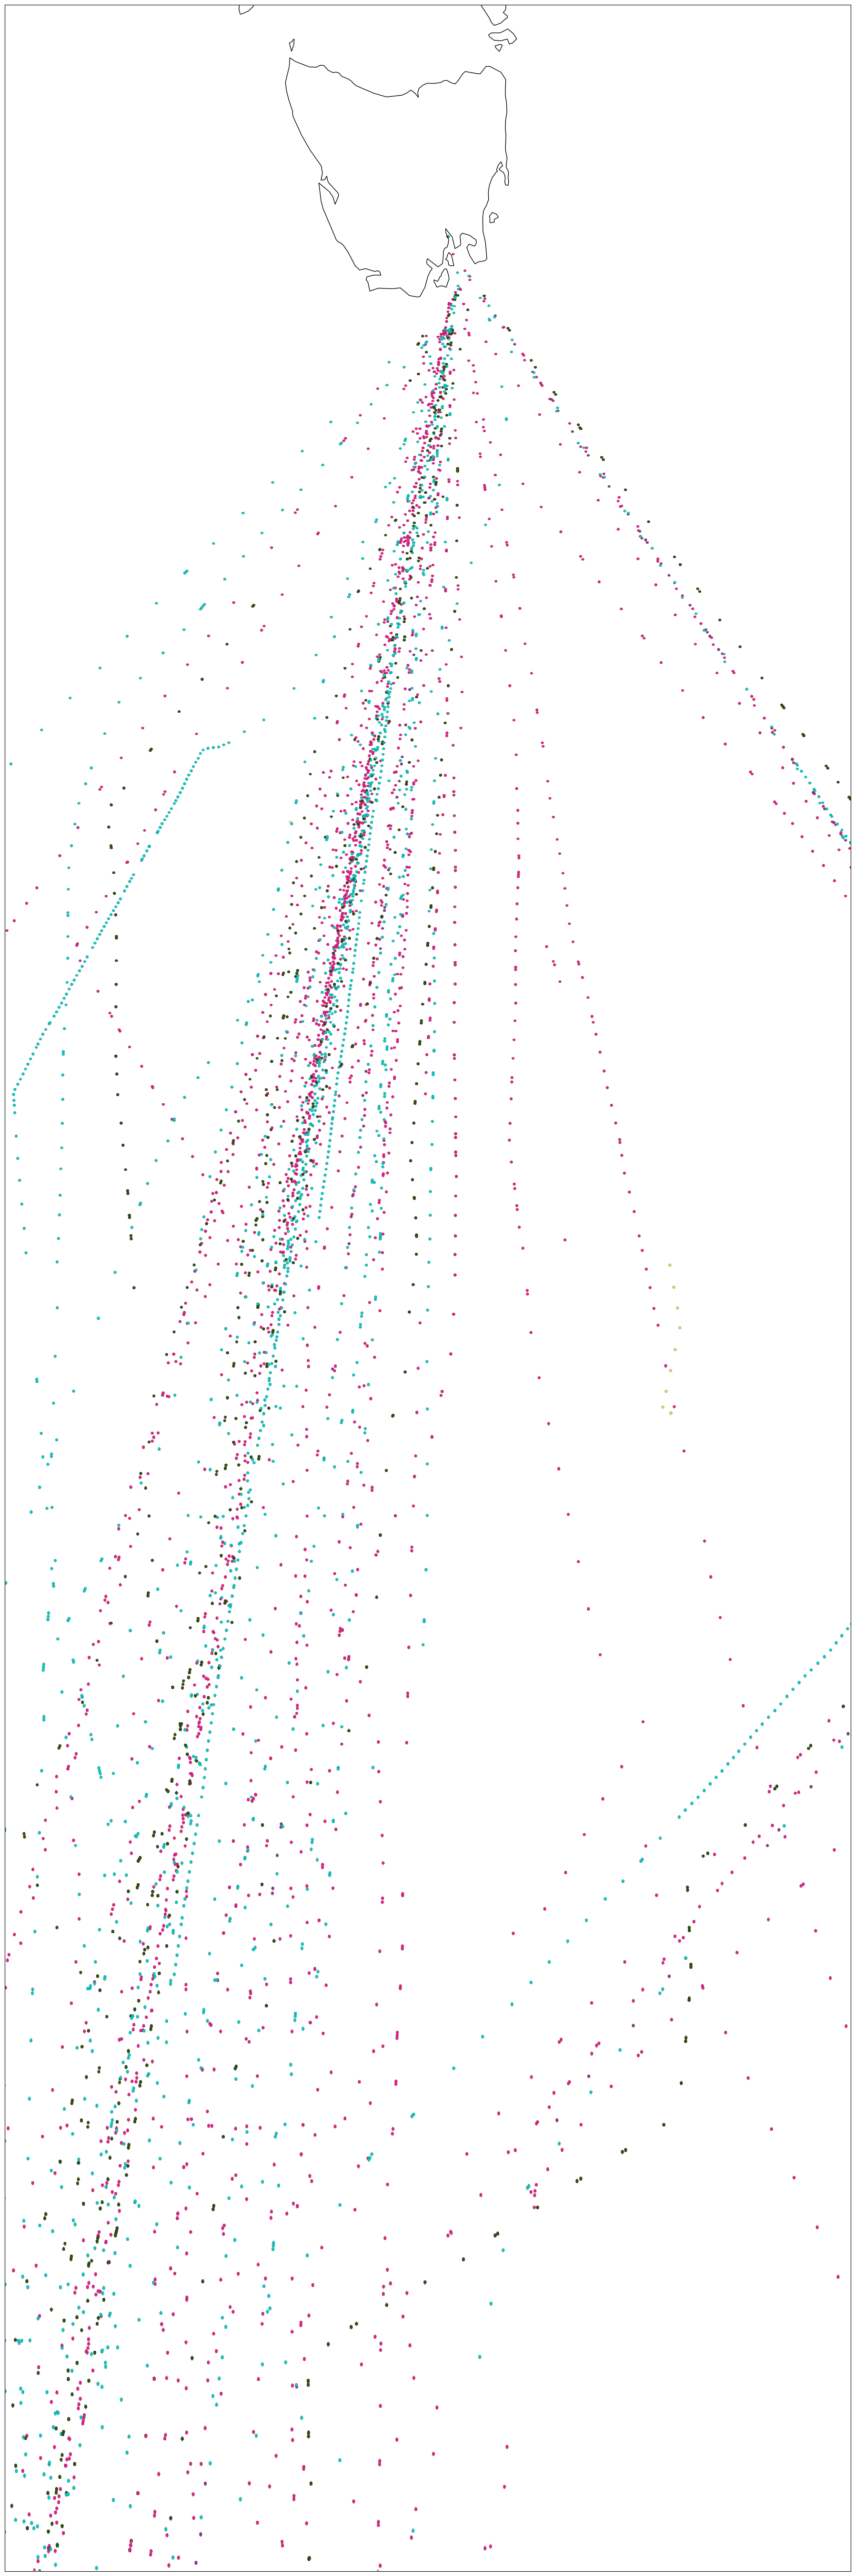

In [7]:
# Define the WMS and WFS layer names and the bounding box
layer1_wms_name = 'imos:soop_xbt_nrt_profiles_map'
layer1_wfs_name = 'imos:soop_xbt_nrt_profiles_data'
bounding_box_wms = [140, 154, -65, -40]  # [lon_min, lon_max, lat_min, lat_max]

# Create the plot
fig = plt.figure(figsize=(30, 70))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

# Set the extent
ax.set_extent(bounding_box_wms, crs=ccrs.PlateCarree())

# Add coastlines
ax.coastlines(resolution='50m', color='black', linewidth=1)

# Add WMS layer
ax.add_wms(wms=GEOSERVER_WMS_LAYER, layers=layer1_wms_name)

plt.show()

<a id="QueryXBT"></a>
## 3. Querying XBT data via WFS

In [8]:
wfs = WebFeatureService(url=GEOSERVER_WFS_LAYER, version='1.1.0', timeout=30)
#[operation.name for operation in wfs.operations]
xbt_nrt = wfs[layer1_wms_name]

# BBox filters south of Tasmania
lon_min = 142
lon_max = 146
lat_min = -48
lat_max = -46
bbox = [lon_min, lat_min, lon_max, lat_max]  # [lon_min, lat_min, lon_max, lat_max]
filter_1 = BBox(bbox, wfs.contents[layer1_wfs_name].crsOptions[0].getcodeurn())

## string property. In this section, we filter on the callsign for the Astrolabe vessel. 
filename_wfs_filter ='FHZI' 
column = 'Callsign' 
filter_2 = PropertyIsLike(propertyname=column, literal=filename_wfs_filter, wildCard='%')

# add both filters with AND operator and convert to XML
filters = And([filter_1, filter_2])
filters_xml = etree.tostring(filters.toXML()).decode("utf-8")

response = wfs.getfeature(typename=layer1_wfs_name, bbox=bbox, outputFormat='application/json')
#response = wfs.getfeature(typename=layer1_wfs_name, bbox=bbox, outputFormat='application/json', maxfeatures=1)
res = response.read()

json_output = json.dumps(json.loads(res))


data = json.loads(json_output)
df_xbt = json_normalize(data['features'])

df_xbt.head()  # display the first few rows

,type,id,geometry_name,geometry.type,geometry.coordinates,properties.profile_id,properties.measurement_id,properties.XBT_line,properties.XBT_line_description,properties.Callsign,...,properties.XBT_instrument_serialnumber,properties.XBT_calibration_OFFS,properties.XBT_calibration_SCAL,properties.TIME,properties.LONGITUDE,properties.LATITUDE,properties.DEPTH,properties.DEPTH_quality_control,properties.TEMP,properties.TEMP_quality_control
0,Feature,soop_xbt_nrt_profiles_data.fid--706568b6_19080...,geom,Point,"[145.8572, -47.6479]",1274,160968,None,None,FHZI,...,None,None,None,2013-01-05T16:13:00Z,145.857241,-47.647931,4.0,NaN,10.750,NaN
1,Feature,soop_xbt_nrt_profiles_data.fid--706568b6_19080...,geom,Point,"[145.8572, -47.6479]",1274,160969,None,None,FHZI,...,None,None,None,2013-01-05T16:13:00Z,145.857241,-47.647931,38.0,NaN,10.705,NaN
2,Feature,soop_xbt_nrt_profiles_data.fid--706568b6_19080...,geom,Point,"[145.8572, -47.6479]",1274,160970,None,None,FHZI,...,None,None,None,2013-01-05T16:13:00Z,145.857241,-47.647931,47.5,NaN,10.410,NaN
3,Feature,soop_xbt_nrt_profiles_data.fid--706568b6_19080...,geom,Point,"[145.8572, -47.6479]",1274,160971,None,None,FHZI,...,None,None,None,2013-01-05T16:13:00Z,145.857241,-47.647931,72.0,NaN,10.240,NaN
4,Feature,soop_xbt_nrt_profiles_data.fid--706568b6_19080...,geom,Point,"[145.8572, -47.6479]",1274,160972,None,None,FHZI,...,None,None,None,2013-01-05T16:13:00Z,145.857241,-47.647931,79.5,NaN,9.780,NaN


<a id="PlotTemp"></a>
### I. Plot of a specific temperature profile

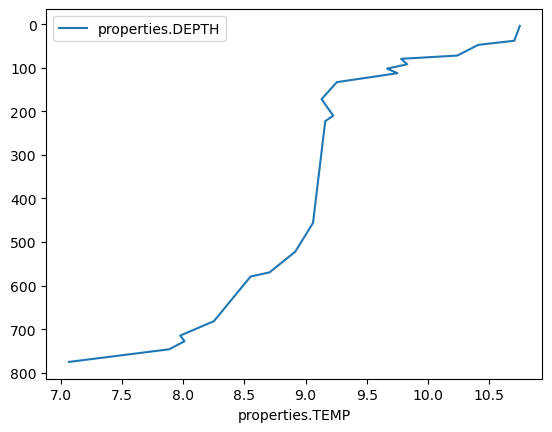

In [9]:
variables = df_xbt.columns
profile_id_to_plot = 1274
profile_data = df_xbt[df_xbt['properties.profile_id'] == profile_id_to_plot]
profile_data.plot(x='properties.TEMP', y='properties.DEPTH').invert_yaxis()

<a id="PlotXBT"></a>
### II. Plot XBT profiles for all months of February

Text(0.5, 0, 'Temperature / Deg')

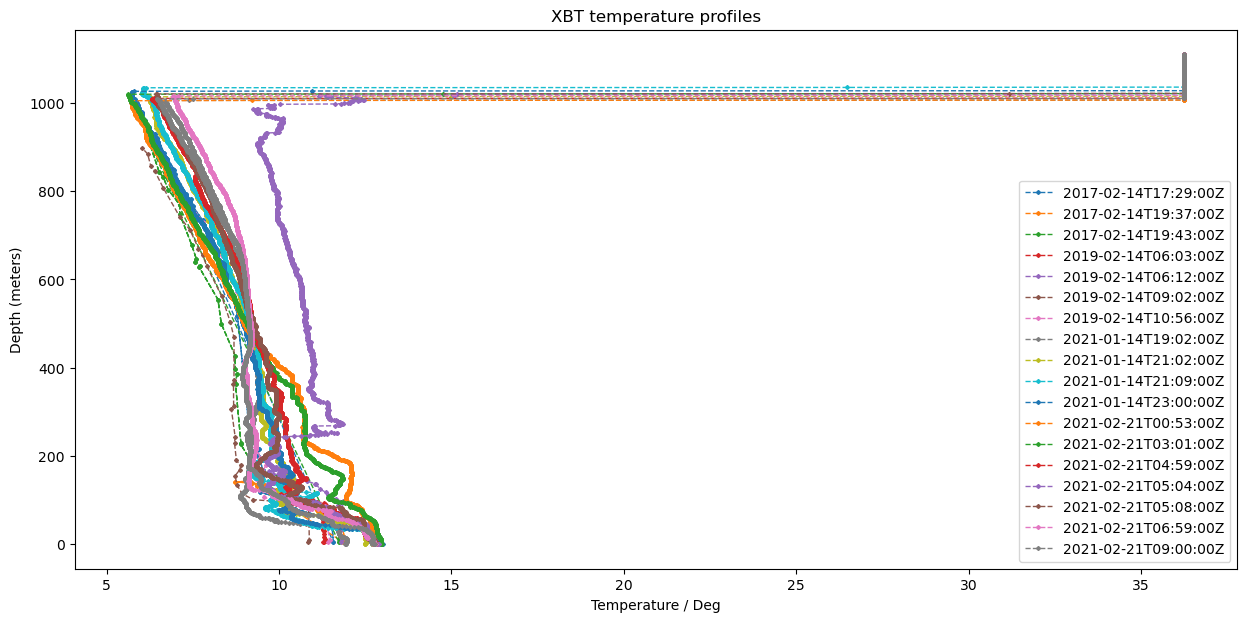

In [10]:
pd.to_datetime(df_xbt['properties.TIME'])  # converting TIME values to date type

profile_data_xbt = df_xbt[
    (pd.to_datetime(df_xbt['properties.TIME']) >= '2017-01-01') &
    (pd.to_datetime(df_xbt['properties.TIME']) <= '2021-12-31')
].copy()
#profile_data = df[ pd.to_datetime(df['properties.TIME']) > '2017-02-26T11:24:00Z'].copy()

# Plot Temperature profile
fig, ax = plt.subplots(figsize=(15,7))

for label, df_sub in profile_data_xbt.groupby('properties.TIME'):
    df_sub.plot(x='properties.TEMP',
                y='properties.DEPTH',
                title='XBT temperature profiles',
                linestyle='dashed',
                marker='D',
                ax=ax,
                label=label,
                linewidth=1,  
                markersize=2)  
    ax.invert_yaxis()

ax.set_ylabel('Depth (meters)')
ax.set_xlabel('Temperature / Deg')

<a id="Search"></a>
## 4. Looking for Argo data in a similar region, all months of February

In [11]:
aodn_collection_to_search_str = "argo"
matching = [s.lower() for s in wms_wfs_ls if aodn_collection_to_search_str.lower() in s]
print(matching)

layer1_wms_name = 'imos:argo_profile_map'
layer1_wfs_name = 'imos:argo_primary_profile_core_low_res_good_qc_data'

wfs = WebFeatureService(url=GEOSERVER_WFS_LAYER, version='1.1.0', timeout=120)

# BBox filters south of Tasmania
bbox = [145, -46, 146, -44]  # [lon_min, lat_min, lon_max, lat_max]

response = wfs.getfeature(typename=layer1_wfs_name, bbox=bbox, outputFormat='application/json')
res = response.read()

json_output = json.dumps(json.loads(res))

data = json.loads(json_output)
df_argo = json_normalize(data['features'])

df_argo.head()

['imos:argo_profile_bio_map', 'imos:argo_profile_map']


,type,id,geometry_name,geometry.type,geometry.coordinates,properties.url,properties.size,properties.data_centre_name,properties.oxygen_sensor,properties.platform_number,...,properties.temp,properties.temp_qc,properties.temp_adjusted,properties.temp_adjusted_qc,properties.temp_adjusted_error,properties.psal,properties.psal_qc,properties.psal_adjusted,properties.psal_adjusted_qc,properties.psal_adjusted_error
0,Feature,argo_primary_profile_core_low_res_good_qc_data...,position,Point,"[145.977, -45.844]",IMOS/Argo/dac/aoml/5904430/profiles/D5904430_0...,27276,AOML,False,5904430,...,12.884,1,12.884,1,0.002,34.668,1,34.668568,1,0.01
1,Feature,argo_primary_profile_core_low_res_good_qc_data...,position,Point,"[145.977, -45.844]",IMOS/Argo/dac/aoml/5904430/profiles/D5904430_0...,27276,AOML,False,5904430,...,12.883,1,12.883,1,0.002,34.701,1,34.701168,1,0.01
2,Feature,argo_primary_profile_core_low_res_good_qc_data...,position,Point,"[145.977, -45.844]",IMOS/Argo/dac/aoml/5904430/profiles/D5904430_0...,27276,AOML,False,5904430,...,12.824,1,12.824,1,0.002,34.709,1,34.708897,1,0.01
3,Feature,argo_primary_profile_core_low_res_good_qc_data...,position,Point,"[145.977, -45.844]",IMOS/Argo/dac/aoml/5904430/profiles/D5904430_0...,27276,AOML,False,5904430,...,12.835,1,12.835,1,0.002,34.732,1,34.731922,1,0.01
4,Feature,argo_primary_profile_core_low_res_good_qc_data...,position,Point,"[145.977, -45.844]",IMOS/Argo/dac/aoml/5904430/profiles/D5904430_0...,27276,AOML,False,5904430,...,12.829,1,12.829,1,0.002,34.737,1,34.738026,1,0.01


In [12]:
df_argo['properties.juld'] = pd.to_datetime(df_argo['properties.juld'], format='ISO8601')

# profile_data_argo = df_argo[(pd.to_datetime(profile_data_xbt['properties.juld']) >= '2017-01-01') & (pd.to_datetime(profile_data_xbt['properties.juld']) <= '2021-12-31')].copy()

profile_data_argo = df_argo[pd.to_datetime(df_argo['properties.juld']).dt.month == 2].copy()
#profile_data = df[ pd.to_datetime(df['properties.TIME']) > '2017-02-26T11:24:00Z'].copy()

Text(0, 0.5, 'Temperature / Deg')

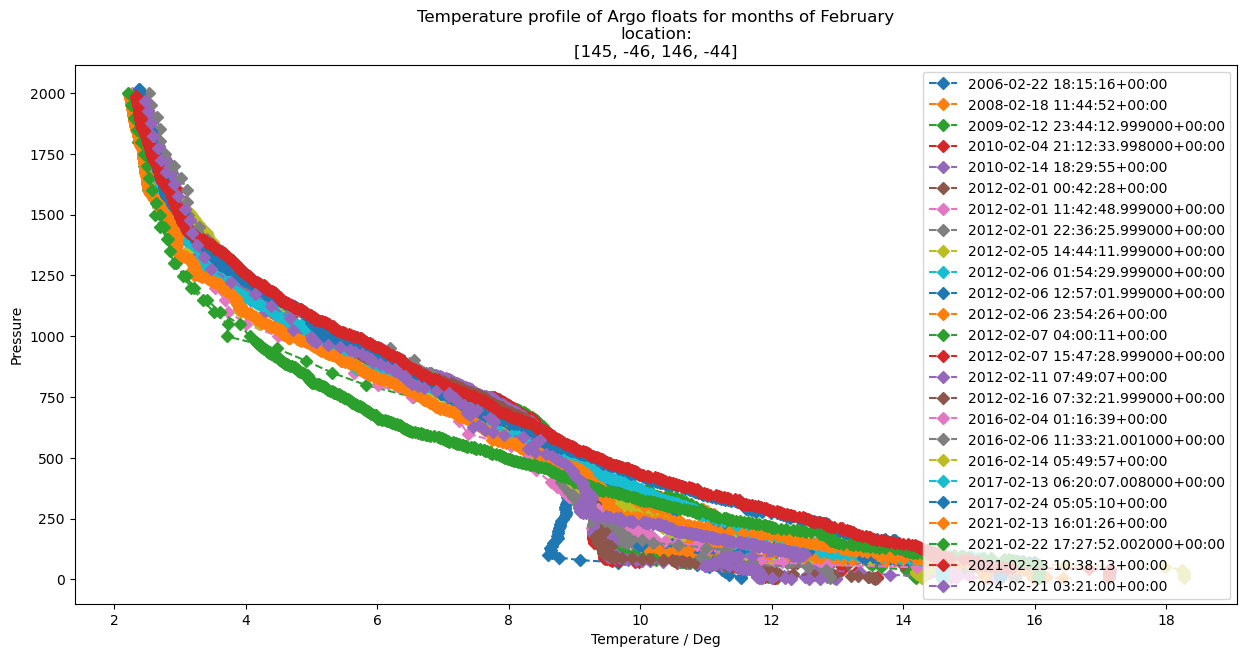

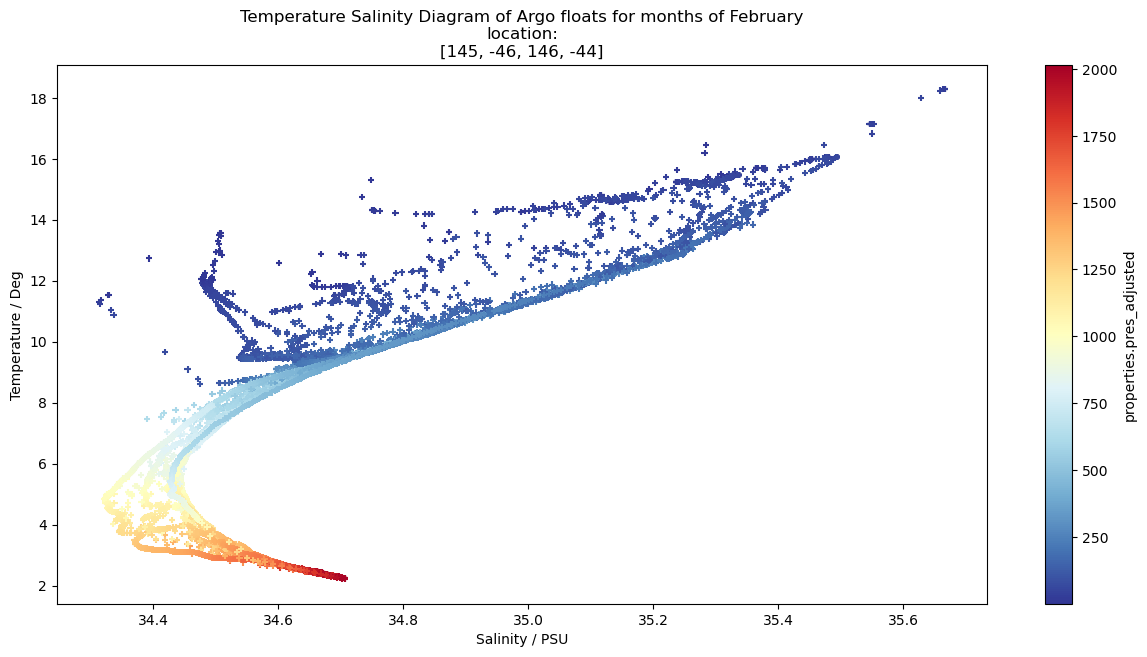

In [13]:
# Plot Temperature profile
fig, ax = plt.subplots(figsize=(15,7))

for label, df_sub in profile_data_argo.groupby('properties.juld'):
    df_sub.plot(x='properties.temp_adjusted', 
                y='properties.pres_adjusted',
                title='Temperature profile of Argo floats for months of February\nlocation:\n{location}'.
                format(location=bbox),
                linestyle='dashed',marker='D', ax=ax, label=label)#.invert_yaxis()

ax.set_ylabel('Pressure')
ax.set_xlabel('Temperature / Deg')

# TS diagram    
fig2, ax2 = plt.subplots(figsize=(15,7))
profile_data_argo.plot.scatter(x='properties.psal_adjusted', 
                               y='properties.temp_adjusted', 
                               c='properties.pres_adjusted', 
                               title='Temperature Salinity Diagram of Argo floats for months of February\nlocation:\n{location}'.
                               format(location=bbox),
                               marker='+', linestyle="None", ax=ax2,
                               cmap='RdYlBu_r')


ax2.set_xlabel('Salinity / PSU')
ax2.set_ylabel('Temperature / Deg')

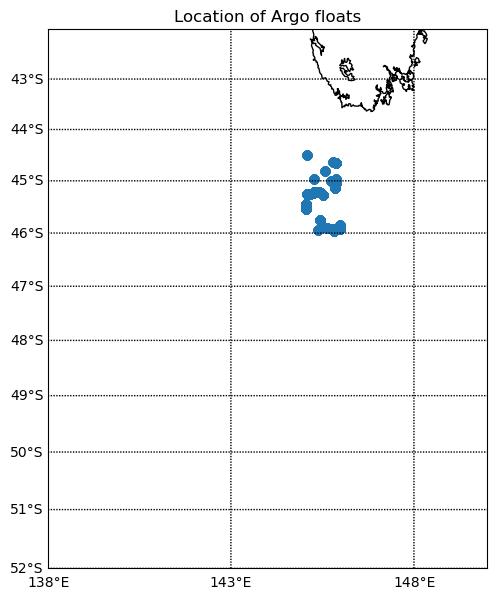

In [14]:
fig, ax = plt.subplots(figsize=(12,7))
# Define the projection, scale, the corners of the map, and the resolution.
degree_delta = 4
m = Basemap(projection='merc',llcrnrlat=lat_min - degree_delta,urcrnrlat=lat_max + degree_delta,\
            llcrnrlon=lon_min - degree_delta,urcrnrlon=lon_max + degree_delta,lat_ts=10,resolution='i')

m.drawcoastlines()
parallels = np.arange(lat_min - degree_delta, lat_max + degree_delta,(lat_max - lat_min)/2.)
m.drawparallels(parallels, labels=[1,0,0,0])

meridians = np.arange(lon_min - degree_delta, lon_max + degree_delta, 5.)
m.drawmeridians(meridians,labels=[True,True,False,True])

lats = profile_data_argo['properties.latitude']
lons = profile_data_argo['properties.longitude']

x, y = m(np.array(lons), np.array(lats))
m.scatter(x, y)
ax.set_title('Location of Argo floats')

plt.show()

<a id="GliderSTas"></a>
## 5. Glider Data South of Tasmania for comparaison

In [15]:
aodn_collection_to_search_str = "anfog"
matching = [s.lower() for s in wms_wfs_ls if aodn_collection_to_search_str.lower() in s]
print(matching)

layer1_wms_name = 'imos:anfog_dm_trajectory_map'
layer1_wfs_name = 'imos:anfog_dm_trajectory_data'

wfs = WebFeatureService(url=GEOSERVER_WFS_LAYER, version='1.1.0', timeout=30)

# BBox filters south of Tasmania
bbox = [145, -46, 146, -44]  # [lon_min, lat_min, lon_max, lat_max] -44.836, 145.668 to Lat/Lon -44.204, 146.464

response = wfs.getfeature(typename=layer1_wfs_name, bbox=bbox, outputFormat='application/json')
res = response.read()

json_output = json.dumps(json.loads(res))

data = json.loads(json_output)
df_anfog = json_normalize(data['features'])

pd.to_datetime(df_anfog['properties.TIME'])  # converting TIME values to date type

df_anfog.head()

['imos:anfog_dm_trajectory_map', 'imos:anfog_rt_trajectory_map']


,type,id,geometry_name,geometry.type,geometry.coordinates,properties.file_id,properties.deployment_name,properties.platform_type,properties.platform_code,properties.time_coverage_start,...,properties.VCUR_GPS,properties.VCUR_GPS_quality_control,properties.IRRAD443,properties.IRRAD443_quality_control,properties.IRRAD490,properties.IRRAD490_quality_control,properties.IRRAD555,properties.IRRAD555_quality_control,properties.IRRAD670,properties.IRRAD670_quality_control
0,Feature,anfog_dm_trajectory_data.fid--706568b6_190805a...,geom,Point,"[145.3171, -44.7239]",287,SOTS20100913,seaglider,SG521,2010-09-13T07:20:19Z,...,NaN,0,None,None,None,None,None,None,None,None
1,Feature,anfog_dm_trajectory_data.fid--706568b6_190805a...,geom,Point,"[145, -44.8091]",287,SOTS20100913,seaglider,SG521,2010-09-13T07:20:19Z,...,NaN,0,None,None,None,None,None,None,None,None
2,Feature,anfog_dm_trajectory_data.fid--706568b6_190805a...,geom,Point,"[145, -44.8091]",287,SOTS20100913,seaglider,SG521,2010-09-13T07:20:19Z,...,NaN,0,None,None,None,None,None,None,None,None
3,Feature,anfog_dm_trajectory_data.fid--706568b6_190805a...,geom,Point,"[145, -44.8091]",287,SOTS20100913,seaglider,SG521,2010-09-13T07:20:19Z,...,NaN,0,None,None,None,None,None,None,None,None
4,Feature,anfog_dm_trajectory_data.fid--706568b6_190805a...,geom,Point,"[145.0001, -44.8091]",287,SOTS20100913,seaglider,SG521,2010-09-13T07:20:19Z,...,NaN,0,None,None,None,None,None,None,None,None


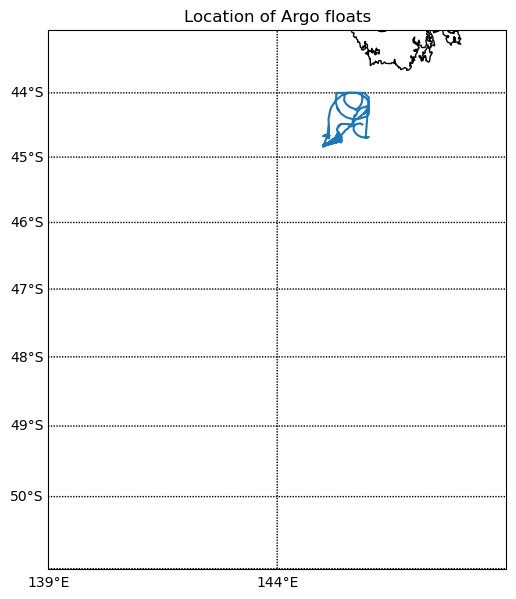

In [16]:
fig, ax = plt.subplots(figsize=(12,7))
# Define the projection, scale, the corners of the map, and the resolution.
degree_delta = 3
m = Basemap(projection='merc',llcrnrlat=lat_min - degree_delta,urcrnrlat=lat_max + degree_delta,\
            llcrnrlon=lon_min - degree_delta,urcrnrlon=lon_max + degree_delta,lat_ts=10,resolution='i')

m.drawcoastlines()
parallels = np.arange(lat_min - degree_delta, lat_max + degree_delta,(lat_max - lat_min)/2.)
m.drawparallels(parallels, labels=[1,0,0,0])

meridians = np.arange(lon_min - degree_delta, lon_max + degree_delta, 5.)
m.drawmeridians(meridians,labels=[True,True,False,True])

lats = df_anfog['properties.LATITUDE']
lons = df_anfog['properties.LONGITUDE']

x, y = m(np.array(lons), np.array(lats))
m.plot(x, y)
ax.set_title('Location of Argo floats')

plt.show()

Text(0, 0.5, 'Temperature / Deg')

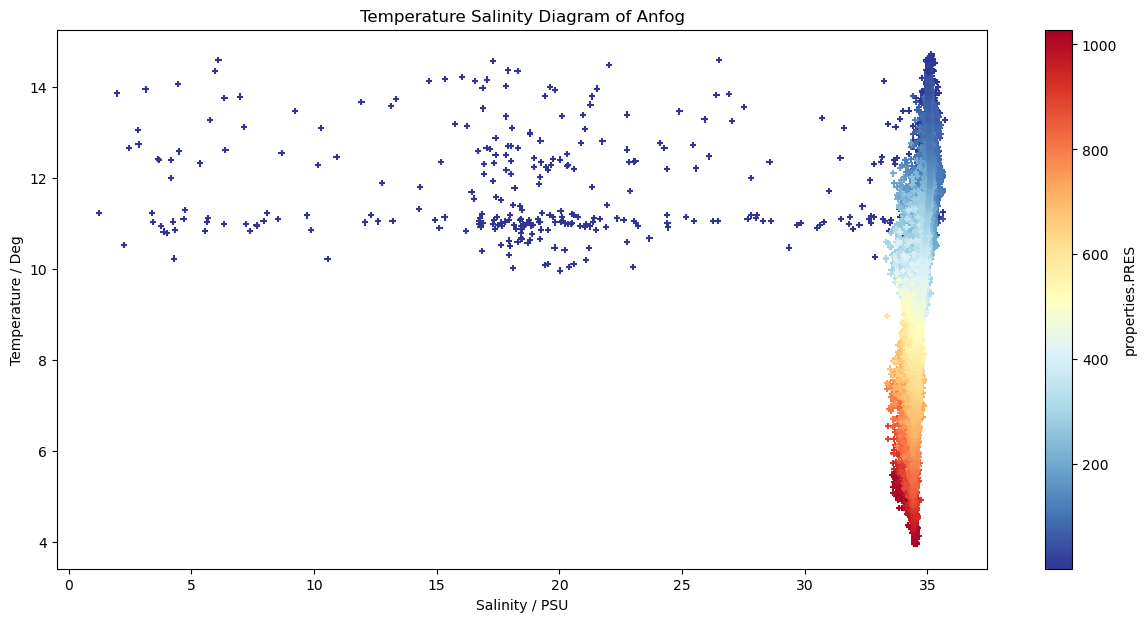

In [17]:
# TS diagram    
fig2, ax2 = plt.subplots(figsize=(15,7))
df_anfog.plot.scatter(x='properties.PSAL', 
                               y='properties.TEMP', 
                               c='properties.PRES', 
                               title='Temperature Salinity Diagram of Anfog',
                               marker='+', linestyle="None", ax=ax2,
                               cmap='RdYlBu_r')


ax2.set_xlabel('Salinity / PSU')
ax2.set_ylabel('Temperature / Deg')

Text(0, 0.5, 'Pressure')

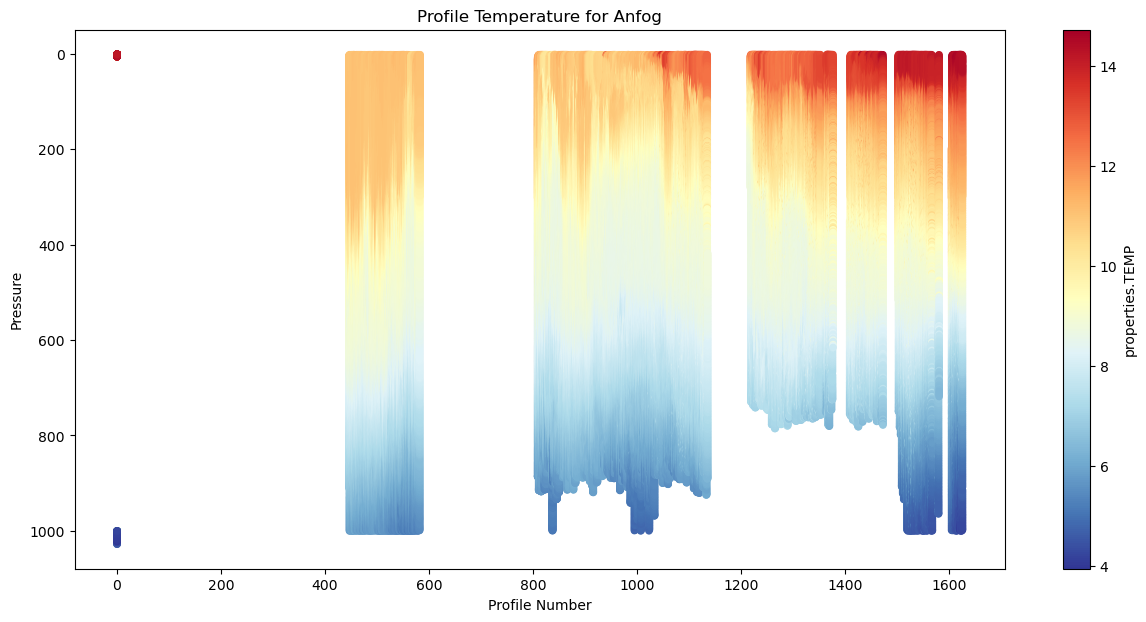

In [18]:
# Profile  
fig2, ax2 = plt.subplots(figsize=(15,7))
df_anfog.plot.scatter(x='properties.PROFILE',
              y='properties.PRES', 
              c='properties.TEMP',
              title='Profile Temperature for Anfog',
              ax=ax2,
              cmap='RdYlBu_r'
              ).invert_yaxis()


ax2.set_xlabel('Profile Number')
ax2.set_ylabel('Pressure')


In [19]:
df_anfog.columns

Index(['type', 'id', 'geometry_name', 'geometry.type', 'geometry.coordinates',
       'properties.file_id', 'properties.deployment_name',
       'properties.platform_type', 'properties.platform_code',
       'properties.time_coverage_start', 'properties.time_coverage_end',
       'properties.TIME', 'properties.TIME_quality_control',
       'properties.LATITUDE', 'properties.LATITUDE_quality_control',
       'properties.LONGITUDE', 'properties.LONGITUDE_quality_control',
       'properties.PRES', 'properties.PRES_quality_control',
       'properties.DEPTH', 'properties.DEPTH_quality_control',
       'properties.PROFILE', 'properties.PROFILE_quality_control',
       'properties.PHASE', 'properties.PHASE_quality_control',
       'properties.TEMP', 'properties.TEMP_quality_control', 'properties.PSAL',
       'properties.PSAL_quality_control', 'properties.DOX1',
       'properties.DOX1_quality_control', 'properties.DOX2',
       'properties.DOX2_quality_control', 'properties.CPHL',
       '